In [1]:
import pandas as pd
import os

parent_dir = os.path.dirname(os.getcwd())
train = pd.read_csv(parent_dir + '/dm2_dataset_2425_imdb/train70_clf.csv')
test = pd.read_csv(parent_dir + '/dm2_dataset_2425_imdb/test30_clf.csv')

In [2]:
# Drop observations where titleType is 'videoGame'
train = train[train['titleType'] != 'videoGame']
test = test[test['titleType'] != 'videoGame']

# Define a mapping dictionary for titleType
titletype_mapping = {
    'movie': 'movie',
    'tvMovie': 'movie',
    'short': 'short',
    'tvShort': 'short',
    'tvSeries': 'tvSeries',
    'tvMiniSeries': 'tvSeries',
    'tvEpisode': 'tvEpisode',
    'tvSpecial': 'tvSpecial',
    'video': 'video'
}

# Apply the mapping to the titleType column
train['titleType'] = train['titleType'].map(titletype_mapping)
test['titleType'] = test['titleType'].map(titletype_mapping)

# Check the new unique values
print("New unique values in titleType:", train['titleType'].unique())

New unique values in titleType: ['movie' 'short' 'tvEpisode' 'tvSeries' 'video' 'tvSpecial']


In [3]:
from sklearn.preprocessing import LabelEncoder

X_train = train.drop(columns=['titleType', 'canHaveEpisodes'])
y_train = train['titleType']

X_test = test.drop(columns=['titleType', 'canHaveEpisodes'])
y_test = test['titleType']

In [4]:
# Preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# One-hot encode y_train for categorical_crossentropy
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Simple neural network model
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# model.summary()

2025-08-30 08:16:42.488407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
history = model.fit(
    X_train, y_train,
    epochs=200, batch_size=64, validation_split=0.2
)

Epoch 1/200
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 36s 11ms/step - accuracy: 0.7438 - loss: 0.7820 - val_accuracy: 0.8579 - val_loss: 0.4270
Epoch 2/200
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8717 - loss: 0.3943 - val_accuracy: 0.8727 - val_loss: 0.3876
Epoch 3/200
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8795 - loss: 0.3682 - val_accuracy: 0.8805 - val_loss: 0.3670
Epoch 4/200
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8849 - loss: 0.3500 - val_accuracy: 0.8794 - val_loss: 0.3595
Epoch 5/200
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8872 - loss: 0.3394 - val_accuracy: 0.8849 - val_loss: 0.3494
Epoch 6/200
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8887 - loss: 0.3330 - val_accuracy: 0.8870 - val_loss: 0.3469
Epoch 7/200
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8911 - loss: 0.3260 - val_accuracy: 0.8882 - val_loss: 0.3414
Epoch 8/200
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8939 

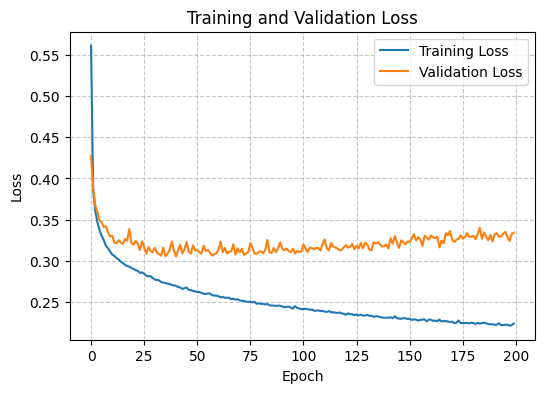

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(alpha=0.7, linestyle='--')
plt.show()

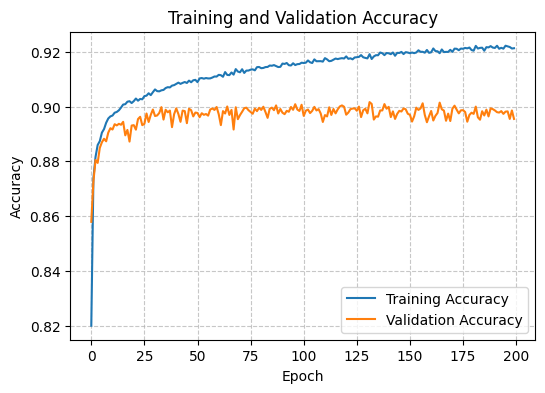

1386/1386 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step


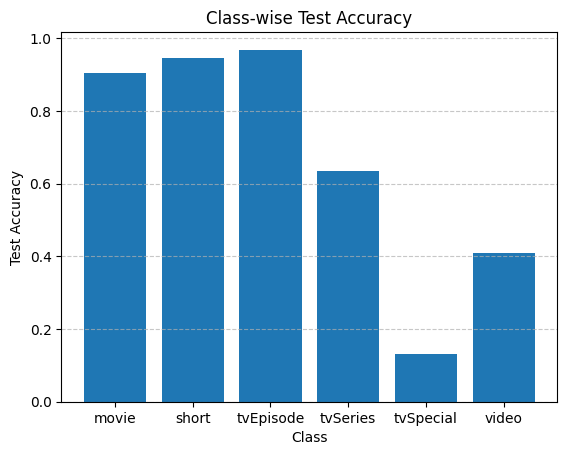

In [9]:
from sklearn.metrics import accuracy_score

# Plot overall accuracy
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(alpha=0.7, linestyle='--')
plt.show()

# Class-wise accuracy on test set

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Calculate accuracy for each class
class_accuracies = {}
for i, class_name in enumerate(le.classes_):
    idx = (y_test == i)
    class_acc = accuracy_score(y_test[idx], y_pred_classes[idx])
    class_accuracies[class_name] = class_acc

# Plot class-wise accuracy
plt.bar(class_accuracies.keys(), class_accuracies.values())
plt.xlabel('Class')
plt.ylabel('Test Accuracy')
plt.title('Class-wise Test Accuracy')
# plt.xticks(rotation=45)
plt.grid(alpha=0.7, linestyle='--', axis='y')
plt.show()

1386/1386 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step
              precision    recall  f1-score   support

       movie       0.90      0.90      0.90     12947
       short       0.86      0.94      0.90      4994
   tvEpisode       0.95      0.97      0.96     21249
    tvSeries       0.72      0.63      0.67      3247
   tvSpecial       0.37      0.13      0.19       345
       video       0.54      0.41      0.47      1545

    accuracy                           0.90     44327
   macro avg       0.72      0.67      0.68     44327
weighted avg       0.89      0.90      0.89     44327



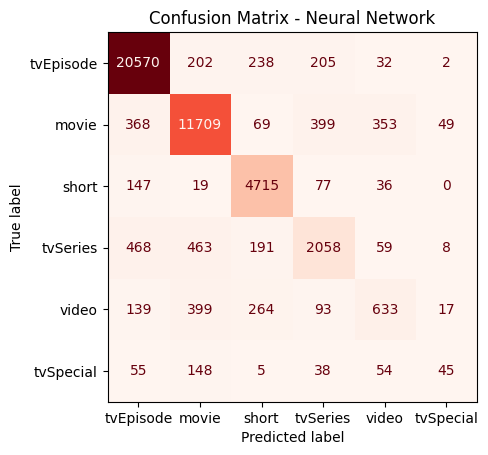

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix


# Predict on the test set
y_pred = model.predict(X_test).argmax(axis=1)

# Print classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Sort confusion matrix by support
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
support = [report[label]['support'] for label in le.classes_]
sorted_indices = sorted(range(len(support)), key=lambda k: support[k], reverse=True)
sorted_labels = [le.classes_[i] for i in sorted_indices]

# 1. Manually create the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=range(len(le.classes_)))

# 2. Sort the confusion matrix based on the sorted_indices
cm_sorted = cm[sorted_indices, :]  # Sort rows
cm_sorted = cm_sorted[:, sorted_indices] # Sort columns

# 3. Create a new ConfusionMatrixDisplay object with the sorted matrix and sorted labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sorted, display_labels=sorted_labels)
disp.xticks_rotation = 45

# 4. Plot the sorted confusion matrix
disp.plot(cmap='Reds', colorbar=False)

plt.title('Confusion Matrix - Neural Network')


plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

In [11]:
from sklearn.metrics import classification_report

# Macro scores
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

              precision    recall  f1-score   support

       movie       0.90      0.90      0.90     12947
       short       0.86      0.94      0.90      4994
   tvEpisode       0.95      0.97      0.96     21249
    tvSeries       0.72      0.63      0.67      3247
   tvSpecial       0.37      0.13      0.19       345
       video       0.54      0.41      0.47      1545

    accuracy                           0.90     44327
   macro avg       0.72      0.67      0.68     44327
weighted avg       0.89      0.90      0.89     44327



1386/1386 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step


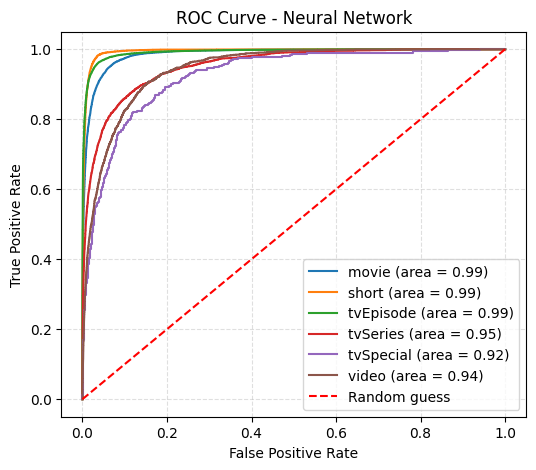

In [12]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve for each rating bin
fpr = {}
tpr = {}
roc_auc = {}
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, model.predict(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(6, 5))
for i in range(6):
    plt.plot(fpr[i], tpr[i], label='{} (area = {:.2f})'.format(le.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.title('ROC Curve - Neural Network')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(linestyle='--', alpha=0.4)
plt.show()

# Rating

In [13]:
train = pd.read_csv(parent_dir + '/dm2_dataset_2425_imdb/train70_clf.csv')
test = pd.read_csv(parent_dir + '/dm2_dataset_2425_imdb/test30_clf.csv')

In [14]:
X_train = train.drop(columns=['averageRating', 'canHaveEpisodes'])
y_train = train['averageRating']

X_test = test.drop(columns=['averageRating', 'canHaveEpisodes'])
y_test = test['averageRating']

# One hot encode the titleType column
X_train = pd.get_dummies(X_train, columns=['titleType'], drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns=['titleType'], drop_first=True, dtype=int)

In [15]:
# Preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

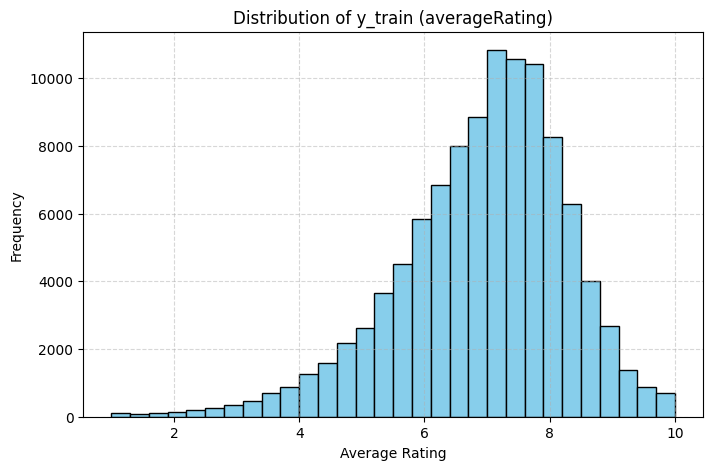

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(y_train, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.title('Distribution of y_train (averageRating)')
plt.grid(alpha=0.5, linestyle='--')
plt.show()

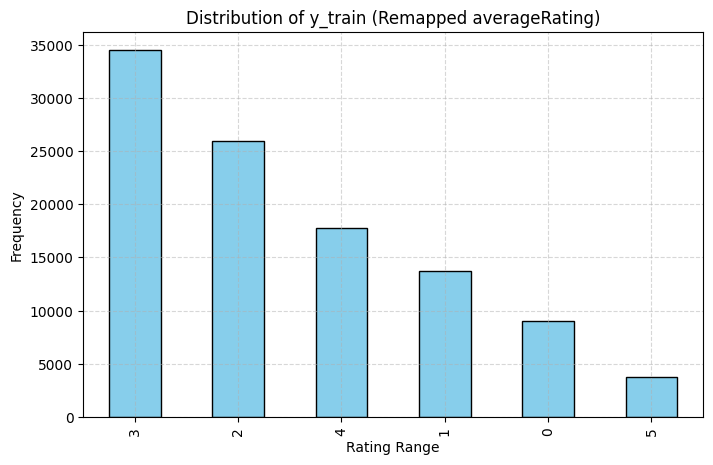

In [17]:
# Map values in intervals to new  bins
def remap_rating(rating):
    if rating < 5:
        return 0
    elif 5 <= rating < 6:
        return 1
    elif 6 <= rating < 7:
        return 2
    elif 7 <= rating < 8:
        return 3
    elif 8 <= rating < 9:
        return 4
    else:  # 9 <= rating <= 10
        return 5
    
# Remap y_train and y_test
y_train = y_train.map(remap_rating)
y_test = y_test.map(remap_rating)

y_train, y_test

# Barplot the new distribution
plt.figure(figsize=(8, 5))
y_train.value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Rating Range')
plt.ylabel('Frequency')
plt.title('Distribution of y_train (Remapped averageRating)')
# plt.xticks(rotation=45)
plt.grid(alpha=0.5, linestyle='--')
plt.show()

In [18]:
# Counts for each class
y_train.value_counts().sort_index()

averageRating
0     8990
1    13725
2    25918
3    34490
4    17774
5     3774
Name: count, dtype: int64

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf

# Neural network for remapped y (averageRating bins)
model_rating = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    # Dense(8, activation='relu'),
    Dense(6, activation='softmax')
])

model_rating.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.1909 - loss: 1.6602 - val_accuracy: 0.2341 - val_loss: 1.6507
Epoch 2/200
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.2579 - loss: 1.5634 - val_accuracy: 0.2708 - val_loss: 1.5988
Epoch 3/200
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.2692 - loss: 1.5490 - val_accuracy: 0.2715 - val_loss: 1.6037
Epoch 4/200
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.2795 - loss: 1.5367 - val_accuracy: 0.2562 - val_loss: 1.6272
Epoch 5/200
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.2774 - loss: 1.5286 - val_accuracy: 0.2783 - val_loss: 1.5984
Epoch 6/200
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.2855 - loss: 1.5133 - val_accuracy: 0.2899 - val_loss: 1.5794
Epoch 7/200
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.2854 - loss: 1.5104 - val_accuracy: 0.3067 - val_loss: 1.5577
Epoch 8/200
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.2928

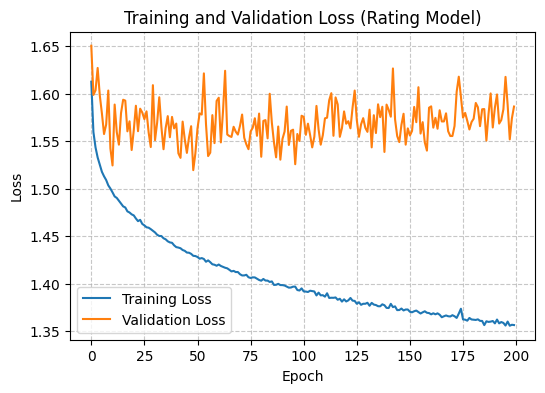

In [20]:
# Compute class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Class weight options: 'balanced', None, or custom dict

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)


history_rating = model_rating.fit(
    X_train, y_train,
    epochs=200, batch_size=64, validation_split=0.2,
    class_weight={i: w for i, w in enumerate(class_weights)}
)

plt.figure(figsize=(6, 4))
plt.plot(history_rating.history['loss'], label='Training Loss')
plt.plot(history_rating.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Rating Model)')
plt.legend()
plt.grid(alpha=0.7, linestyle='--')
plt.show()

In [21]:
class_weights

array([1.94050797, 1.27105039, 0.67309077, 0.50580361, 0.98149919,
       4.6224607 ])

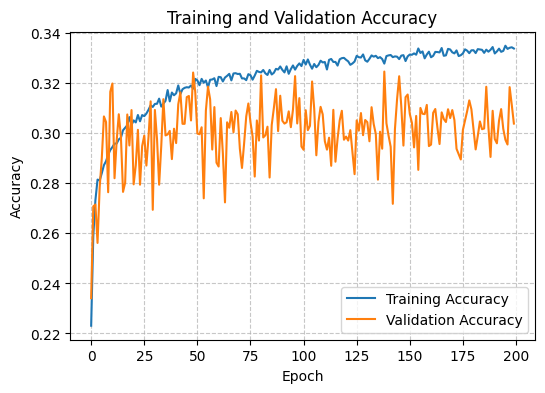

In [22]:
plt.figure(figsize=(6, 4))
plt.plot(history_rating.history['accuracy'], label='Training Accuracy')
plt.plot(history_rating.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(alpha=0.7, linestyle='--')
plt.show()

1402/1402 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

      [0, 5)       0.28      0.45      0.34      3866
      [5, 6)       0.28      0.38      0.32      5851
      [6, 7)       0.42      0.17      0.24     11114
      [7, 8)       0.53      0.30      0.38     14674
      [8, 9)       0.27      0.30      0.28      7640
     [9, 10)       0.11      0.63      0.19      1715

    accuracy                           0.30     44860
   macro avg       0.32      0.37      0.29     44860
weighted avg       0.39      0.30      0.31     44860



<Figure size 400x400 with 0 Axes>

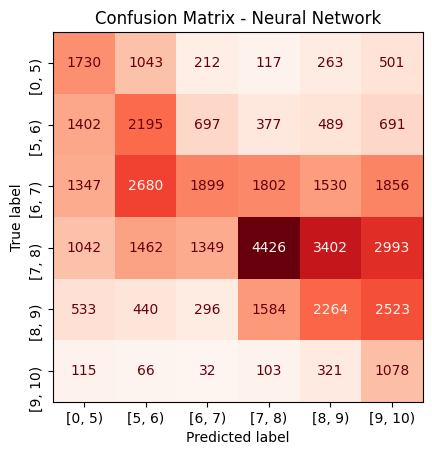

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

target_names = [
    '[0, 5)',
    '[5, 6)',
    '[6, 7)',
    '[7, 8)',
    '[8, 9)',
    '[9, 10)'
]
                

# Predict on the test set
y_pred = model_rating.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=target_names))


plt.figure(figsize=(4, 4))

# 1. Manually create the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes, labels=range(len(target_names)))

# 2. Create a new ConfusionMatrixDisplay object with the original matrix and labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)


disp.xticks_rotation = 45

# 3. Plot the confusion matrix
disp.plot(cmap='Reds', colorbar=False)

plt.xticks(rotation=0)
plt.yticks(rotation=90)
plt.title('Confusion Matrix - Neural Network')
plt.show()

1402/1402 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


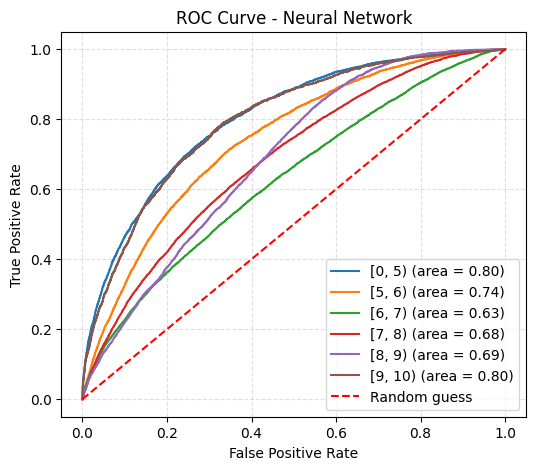

In [24]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve for each rating bin
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(target_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, model_rating.predict(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(6, 5))
for i in range(len(target_names)):
    plt.plot(fpr[i], tpr[i], label='{} (area = {:.2f})'.format(target_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.title('ROC Curve - Neural Network')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(linestyle='--', alpha=0.4)
plt.show()